<a href="https://colab.research.google.com/github/Ad-Chekk/ML_models/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import regex as re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
real = pd.read_csv("True.csv")
fake = pd.read_csv("Fake.csv")

**Let's start by first adding the target value to our real and fake news as 1 , 0 then concatenating both datasets** + **let's shuffle our data and set the seed to ensure reproducibility**

In [ ]:
real['target']=1
fake['target']=0

data = pd.concat([real , fake] , ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


display(data.head())
print('-'*40)

print('shape' , data.shape)
print('-'*40)

display(data.dtypes )
print('-'*40)

display(data.isna().sum())
print('\n we have no null values ' )

,title,text,subject,date,target
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


----------------------------------------
shape (44898, 5)
----------------------------------------


title      object
text       object
subject    object
date       object
target      int64
dtype: object

----------------------------------------


title      0
text       0
subject    0
date       0
target     0
dtype: int64


 we have no null values 


In [ ]:
data.target.value_counts(normalize=True)


target
0    0.522985
1    0.477015
Name: proportion, dtype: float64

**-------------------------------------->**
Here its just to have an estimate on what od the subjects have more fake news **rs1** , and which of them have real news **rs2**
to see if to keep the column or not

In [ ]:
rs1 = data[data['target'] == 0].groupby(['subject'], as_index=False).size()
rs1 = rs1.rename(columns={'size': 'count'}).sort_values(by='count', ascending=False)
print(rs1)

           subject  count
2             News   9050
5         politics   6841
4        left-news   4459
0  Government News   1570
3          US_News    783
1      Middle-east    778


In [ ]:
rs2 = data[data['target'] == 1].groupby(['subject'], as_index=False).size()
rs2 = rs2.rename(columns={'size': 'count'}).sort_values(by='count', ascending=False)
print(rs2)

        subject  count
0  politicsNews  11272
1     worldnews  10145


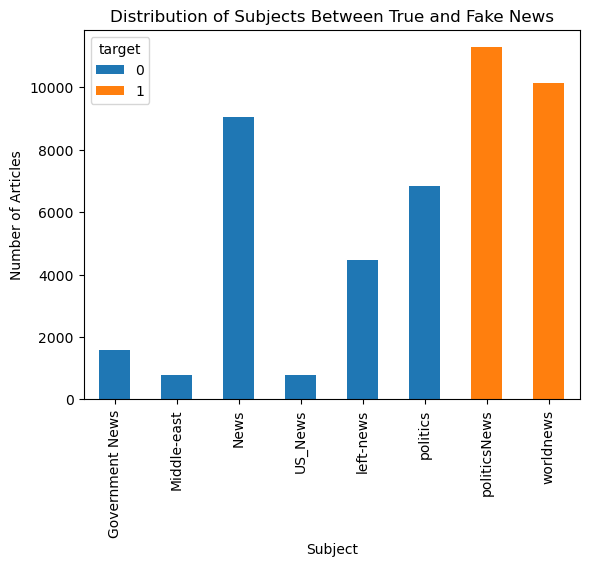

In [ ]:
subject_distribution = data.groupby(['subject', 'target']).size().unstack(fill_value=0)

# Plotting the bar chart using Matplotlib
subject_distribution.plot(kind='bar', stacked=True)

# Adding labels and title
plt.xlabel('Subject')
plt.ylabel('Number of Articles')
plt.title('Distribution of Subjects Between True and Fake News')

# Show the plot
plt.show()


**--------------------->**
clear


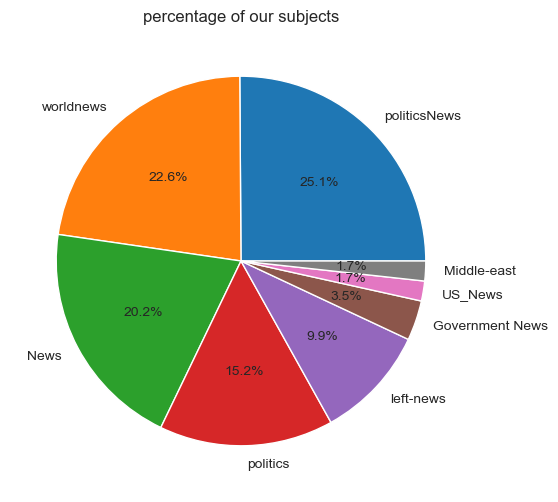

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid") # Set style for chart
plt.figure(figsize=(6,6))
plt.pie(data['subject'].value_counts(),labels=data['subject'].value_counts().index.tolist(), autopct='%1.1f%%')
plt.title('percentage of our subjects')
plt.show()

In [ ]:
data.subject=data.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})


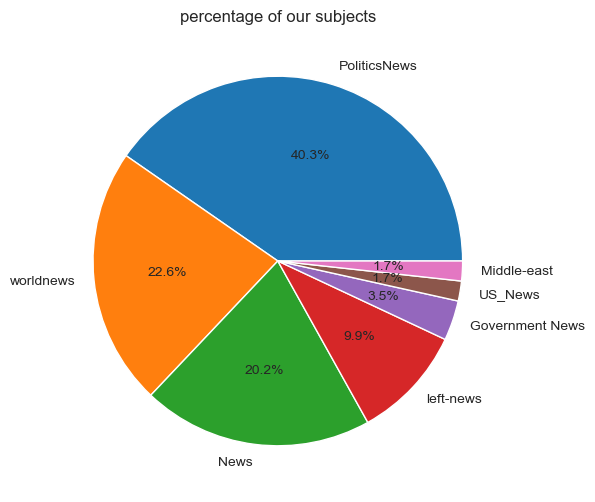

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid") # Set style for chart
plt.figure(figsize=(6,6))
plt.pie(data['subject'].value_counts(),labels=data['subject'].value_counts().index.tolist(), autopct='%1.1f%%')
plt.title('percentage of our subjects')
plt.show()

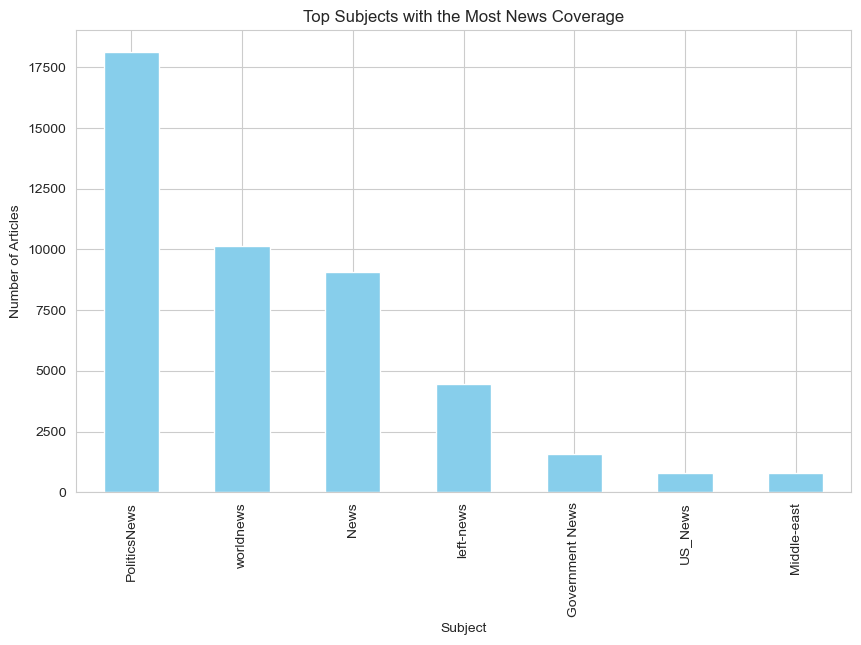

In [ ]:

# Count the number of articles for each subject
subject_counts = data['subject'].value_counts()

# Get the top subjects with the most news coverage
top_subjects = subject_counts.head(10)  # Adjust the number as needed

# Plot the distribution of subjects
top_subjects.plot(kind='bar', figsize=(10, 6), color='skyblue')

# Add titles and labels
plt.title('Top Subjects with the Most News Coverage')
plt.xlabel('Subject')
plt.ylabel('Number of Articles')

# Show plot
plt.show()


Here im calculating the information gain of each feature to see what to keep

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif

# # Assuming 'data' is your DataFrame with the specified data types

# # Step 1: Tokenize and vectorize text data (title and text columns)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
title_text_features = tfidf_vectorizer.fit_transform(data['title'] + ' ' + data['text'])

# # Step 2: Encode categorical variables (subject column)
data_encoded = pd.get_dummies(data, columns=['subject'])

# # Step 3: Extract features from date column if needed

# # Step 4: Combine features for information gain calculation
X = pd.concat([data_encoded.drop(columns=['title', 'text', 'date', 'target']), pd.DataFrame(title_text_features.toarray())], axis=1)
y = data['target']

# # Step 5: Calculate information gain for each feature
info_gain = mutual_info_classif(X, y)

# # Create a DataFrame to show the information gain for each feature
info_gain_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': info_gain})
info_gain_df.sort_values(by='Information Gain', ascending=False, inplace=True)

print(info_gain_df)


KeyboardInterrupt: 

In [ ]:
X[3841]


1. **Feature: 3841, Information Gain: 0.655321**
   - This feature, represented by index 3833, has a high information gain value of approximately 0.655. It indicates that this particular feature (which could be a numerical feature or an encoded categorical feature) is highly informative or predictive of the target variable. Its presence or value strongly influences the prediction of the target variable.

2. **Feature: 3935, Information Gain: 0.259228**
   - The feature represented by index 3927 has an information gain value of approximately 0.259. While not as high as the first feature, this feature still contributes significantly to predicting the target variable. It provides valuable information for making predictions but may not be as influential as the feature with higher information gain.

3. **Feature: subject_politicsNews, Information Gain: 0.237904**
   - This feature corresponds to the subject category "politicsNews" in your dataset, which is one of the subjects. Its information gain value of approximately 0.238 indicates that this subject category is moderately informative or predictive of the target variable. Articles or data points related to politicsNews have some influence on predicting the target variable.

4. **Feature: subject_worldnews, Information Gain: 0.208071**
   - Similarly, this feature corresponds to the subject category "worldnews" with an information gain value of approximately 0.208. It suggests that articles or data points related to world news also contribute to predicting the target variable, although to a slightly lesser extent compared to the politicsNews category.

5. **Features with Information Gain of 0.000**
   - Rows with features that have an information gain value of 0.000 indicate that these features provide no information or very little information for predicting the target variable. They do not contribute significantly to the prediction process based on the information gain calculation.

Overall, the information gain values help prioritize features based on their importance and relevance in predicting the target variable. Features with higher information gain values are more influential in prediction tasks, while features with lower or zero information gain values may be less relevant for prediction.

### *I will add subject to the model as one of the subject features has high info gain*

***
<div style="text-align:center;">
    <span style="font-size:29px; color:green;">Text pre-processing</span>
</div>

![Screenshot (188).png](attachment:84463305-fec6-4c62-a2c7-2792a788c0f6.png)

In [ ]:
data['final'] =  data['title'] + " " + data['subject']


In [ ]:
import nltk
from nltk.corpus import stopwords
from string import punctuation

# Download the stopwords corpus if it's not already downloaded
try:
    nltk.download('stopwords')
except Exception as e:
    print("Stopwords corpus already downloaded.")

# Load the stopwords
stop = set(stopwords.words('english'))

# Add punctuation to the stopwords set
pnc = list(punctuation)
stop.update(pnc)


[nltk_data] Downloading package stopwords to C:\Users\Yadnesh
[nltk_data]     Bhanushali\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [ ]:
stemmer = PorterStemmer()
def stem_text(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            word = stemmer.stem(i.strip())
            final_text.append(word)
    return " ".join(final_text)

In [ ]:
data['final'] = data['final'].apply(stem_text)
data['final'].head(3)


0    breaking: gop chairman grassley enough, demand...
1    fail gop candid rememb hilari mock eulog (vide...
2    mike pence’ new dc neighbor hilari troll homop...
Name: final, dtype: object

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
X_train,X_test,y_train,y_test = train_test_split(data['final'],data['target'])
cv = CountVectorizer(min_df=0,max_df=1,ngram_range=(1,2))

cv_train = cv.fit_transform(X_train)
cv_test = cv.transform(X_test)

print('Train shape: ',cv_train.shape)
print('Test shape: ',cv_test.shape)

Train shape:  (33673, 131662)
Test shape:  (11225, 131662)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


nb = MultinomialNB()
nb.fit(cv_train, y_train)

MultinomialNB()

In [ ]:
pred_nb = nb.predict(cv_test)
score = accuracy_score(y_test, pred_nb)
print("Accuracy Score: ",score)

Accuracy Score:  0.7392427616926504


***

In [ ]:
data['final2'] =  data['text'] + " " + data['title'] + " " + data['subject']
data['final2'] = data['final2'].apply(stem_text)
data['final2'].head(3)


0    donald trump white hous chaos, tri cover up. r...
1    donald trump presumpt gop nominee, time rememb...
2    mike penc huge homophobe. support ex-gay conve...
Name: final2, dtype: object

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(data['final2'],data['target'])
cv = CountVectorizer(min_df=0,max_df=1,ngram_range=(1,2))

cv_train = cv.fit_transform(X_train)
cv_test = cv.transform(X_test)

print('Train shape: ',cv_train.shape)
print('Test shape: ',cv_test.shape)



nb = MultinomialNB()
nb.fit(cv_train, y_train)

pred_nb = nb.predict(cv_test)
score = accuracy_score(y_test, pred_nb)
print("Accuracy Score: ",score)

Train shape:  (33673, 1945690)
Test shape:  (11225, 1945690)
Accuracy Score:  0.9155456570155902
